# Recognize Phones from Speech Sentences using Hidden Markov Model
## Preliminary Testing on a SINGLE vowel

For this project, a hidden markov model (HMM) is applied to create phone models for three different vowels (/a/, /u/, /i/). Then all three phone models are used to infer the state of a given speech sentence. The objective is to recognize the three phones from any given sentence with their corresponding time indices.

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np
import pandas as pd

from hmmlearn_YG import hmm
from python_speech_features import mfcc
from utils.utils import predict_voice_state, load_voice_testing

### Hidden Markov Models

[HMMs](https://en.wikipedia.org/wiki/Hidden_Markov_model) are a class of probabilistic graphical models that can predict the sequence of states, given a sequence of observations that are dependent on those states, and when the states themselves are unobservable. HMMs have seen widespread success in a variety of applications, from Speech processing and Robotics to DNA Sequencing. An HMM operates according to a set of assumptions, which are :  
1. **Markov Assumption**  
Current state is dependent on only the previous state.  
2. **Stationarity Assumption**  
Transition probabilities are independent of time of transition.  
3. **Independence Assumption**  
Each observation depends solely on the current underlying state (which in turn depends on the previous one), and is independent of other observations.  

An HMM is a **Generative model**, in that it attempts to find the probability of a set of observations being produced or *generated* by a class.  The parameters that we pass to the HMM class, defined below, are:  
$O$ = a set of observations  
$S$ = a set of states  
$A$ = transition probabilities, represented as a matrix  
$B$ = emission probabilities, represented as a matrix  
$\pi$ = initial state probabilties  
$Y$ = sequence observed  

## 1. Load Vowel Data for Training the HMM
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [2]:
# Select Subject and Vowel
subject = "R031"
vowel = "a_normal"

In [3]:
# Extract variables that contain related data
vowel_np = np.load("Data/%s/voice_%s.npy" % (subject, vowel))
print(vowel_np.shape)

(55, 2)


## 2. Extract Features from Vowels
Load the vowels and extrac MFCC features from each repetition to construct the training vectors to train the HMM model
### Mel Frequency Cepstral Coefficient (MFCC) 
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.

Example:
<img src="Figure/time_signal.jpg" width="700"/>
<img src="Figure/mfcc_raw.jpg" width="700"/>

### Reference
Davis, S. Mermelstein, P. (1980) Comparison of Parametric Representations for Monosyllabic Word Recognition in Continuously Spoken Sentences. In IEEE Transactions on Acoustics, Speech, and Signal Processing, Vol. 28 No. 4, pp. 357-366

X. Huang, A. Acero, and H. Hon. Spoken Language Processing: A guide to theory, algorithm, and system development. Prentice Hall, 2001.

In [4]:
mfcc_feat = mfcc(vowel_np[0,0], vowel_np[0,1], 
                 0.025, 0.01)
print("Original dimension of voice signal: ", vowel_np[0,0].shape)
print("Dimension of extracted features: ", mfcc_feat.shape)

Original dimension of voice signal:  (27801,)
Dimension of extracted features:  (138, 13)


In [5]:
vowel_feature = np.empty((0,13))
length = []
for vowel_sample, vowel_rate in vowel_np[1:55]:
    # MFCC feature vectors are typically computed every 10ms using 
    # an overlapping analysis window of 25ms
    mfcc_feat = mfcc(vowel_sample, vowel_rate, 
                     0.025, 0.01)
    
    # Concatnate individual feature into one single array
    vowel_feature = np.append(vowel_feature, mfcc_feat, axis=0)
    length.append(int(mfcc_feat.shape[0]))

In [6]:
print('Total # of feature sequences: ', length)

Total # of feature sequences:  [166, 162, 170, 168, 164, 173, 129, 154, 157, 163, 159, 150, 157, 164, 173, 160, 151, 169, 164, 147, 156, 170, 160, 164, 159, 158, 153, 165, 160, 167, 153, 161, 160, 161, 153, 163, 150, 156, 163, 160, 158, 141, 139, 155, 159, 140, 150, 152, 158, 149, 149, 158, 133, 134]


## 3. Training a HMM Model
Use Gaussian distribution for estimating emission probabilities
        <img src="Figure/HMM-based-phone-model.png" width="500"/>

In [7]:
num_components = 3

# Initialize HMM model and estimate parameters for base phone
transmat = np.matrix([[0.5, 0.5, 0],
                      [0, 0.5, 0.5],
                      [0, 0, 1]])

print("State transition probability matrix:\n", transmat)

# Always start in first state
startprob = np.zeros(3)
startprob[0] = 1.0

print("State initial probabilities:\n",startprob)

State transition probability matrix:
 [[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]
State initial probabilities:
 [1. 0. 0.]


### Initialization Option 1: K-Means Clustering
Use KMeans clustering to estimate the means for all states (this was implemented inside the GaussianHMM function).

In [ ]:
model_vowel = hmm.GaussianHMM(n_components=num_components,  
                              covariance_type="full",
                              params="mct", 
                              init_params="cm",
                              n_iter=100)

model_vowel.startprob = startprob.copy()
model_vowel.transmat_ = transmat.copy()

model_vowel.fit(vowel_feature, length)

Results of state estimation on the testing vowel:
<img src="Stat/R031/a_normal_01.png" width="700"/>
<img src="Stat/R031/a_normal_02.png" width="700"/>
<img src="Stat/R031/a_normal_03.png" width="700"/>
<img src="Stat/R031/a_normal_06.png" width="700"/>

### Initialization Option 2
Use a random chosen training repetition to estimate the mean for each state. Assuming each state corresponds to a particular portion of the vowel.

In [9]:
from random import randint

# select one random repetition from training samples to estimate
# the initial mean for each state
# state 0: 0.05
# state 1: 0.85
# state 2: 0.10
voice_tr, vowel_rate = vowel_np[randint(0, 54)]
feature_tr = mfcc(voice_tr, vowel_rate, 0.025, 0.01)

state_init = [0.3, 0.6]
state0 = np.mean(feature_tr[range(0,int(len(feature_tr)*state_init[0]))], axis=0)
state1 = np.mean(feature_tr[range(int(len(feature_tr)*state_init[0])+1,int(len(feature_tr)*state_init[1]))], axis=0)
state2 = np.mean(feature_tr[range(int(len(feature_tr)*state_init[1])+1,int(len(feature_tr)))], axis=0)

state_est = np.array([state0, state1, state2])
print(state_est)

[[ -6.17287145  13.95064132 -24.37063707 -26.4486324  -25.3006051
  -13.24814443  18.26863089   6.73265452 -21.53447585  -6.73495812
  -18.37386552   1.63745745 -23.65767575]
 [ -5.86761593  16.99069775 -21.92759075 -24.46134775 -21.93629353
   -8.85059887  18.97499855   9.15087602 -17.96392834  -4.63759028
  -16.81783863   1.21572774 -19.8484173 ]
 [ -6.66312026  17.41349706 -14.16327456 -28.77805051 -17.44546581
   -8.2200885   11.49736531   9.74015291 -18.77373974  -5.82428934
  -21.68093442  -0.86066013 -21.47808786]]


In [10]:
model_vowel = hmm.GaussianHMM(n_components=num_components,  
                              covariance_type="full",
                              params="mct", 
                              init_params="c",
                              n_iter=100)

model_vowel.means_    = state_est.copy()
model_vowel.startprob = startprob.copy()
model_vowel.transmat_ = transmat.copy()

model_vowel.fit(vowel_feature, length)
model_vowel.monitor_

ConvergenceMonitor(history=[-298096.74323121185, -298096.7354014708], iter=14,
          n_iter=100, tol=0.01, verbose=False)

In [11]:
print(model_vowel.means_)

[[ -7.01628386  12.40965194 -20.53373687 -29.519082   -18.78206242
   -9.37336865  17.33052867   4.03765711 -17.81515436  -3.41369469
  -19.14185699   2.5420612  -24.79612235]
 [ -6.27827144  14.50739546 -22.3455811  -28.66233995 -20.4577869
  -11.61458637  14.68266038   5.73307141 -18.80232604  -4.29226728
  -21.82384092   0.15332116 -21.01546177]
 [ -9.0377967   11.55495283  -3.24600276 -21.15259271  -8.74984378
   -1.3613681    4.60025056  -2.35302108 -15.42562901  -5.51893216
  -23.34002119  -6.54400387 -20.49630854]]


### Initialization Option 3
GMM

## 4. Test the HMM Model on vowels
State sequence order: red   ---> 0, green ---> 1, yello ---> 2

In [18]:
# Load testing vowels and extract features
voice_te, vowel_rate = vowel_np[0]
feature_te = mfcc(vowel_sample, vowel_rate, 0.025, 0.01)
print(len(feature_te))

134


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2]
State 0:  0.1865671641791045
State 1:  0.7313432835820896
State 2:  0.08208955223880597


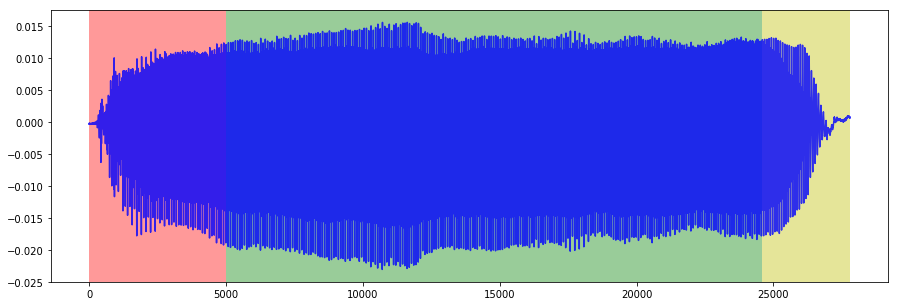

In [13]:
# State prediction on testing vowels
predict_voice_state(model_vowel, voice_te, feature_te, num_components)

In [ ]:
# save the results of mean and covariance for good states prediction
rep = 10
np.save('Stat/%s/%s_mean_%02d.npy' % (subject, vowel, rep), model_vowel.means_)
np.save('Stat/%s/%s_cov_%02d.npy' % (subject, vowel, rep), model_vowel.covars_)
np.save('Stat/%s/%s_cluster_%02d.npy' % (subject, vowel, rep), model_vowel.cluster_center_)
np.savetxt('Stat/%s/%s_mean_%02d.txt' % (subject, vowel, rep), model_vowel.means_, fmt='%.4e')

### 5.2 Using syllable1 as tesing voice signal

“afa afa afa ifi ifi ifi ufu ufu ufu”

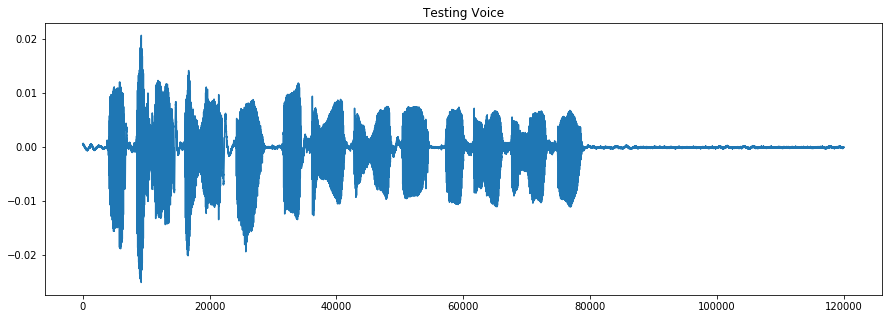

[[-13.51404561 -18.75143901  11.46529551 ...   7.94587196  -0.03427915
    2.25089153]
 [-13.47340793 -27.75485664   9.14315251 ...  15.81391495   7.31416507
    4.0892926 ]
 [-13.40930854 -29.08047525   5.10902181 ...   3.86300113   7.21402017
   11.9618452 ]
 ...
 [-13.8176076  -31.2351921    0.74468252 ...   4.01218564  -0.31992621
    1.56537961]
 [-13.73731948 -29.46656606   3.45326738 ...   7.3609588    1.03103933
   -0.96474185]
 [-13.94520638 -31.20419888  -0.93391541 ...   9.62778248   5.13743289
   -3.67162722]]
[599]


In [17]:
syllable = sio.loadmat('Data/%s/syllable1.mat' % subject)
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0)

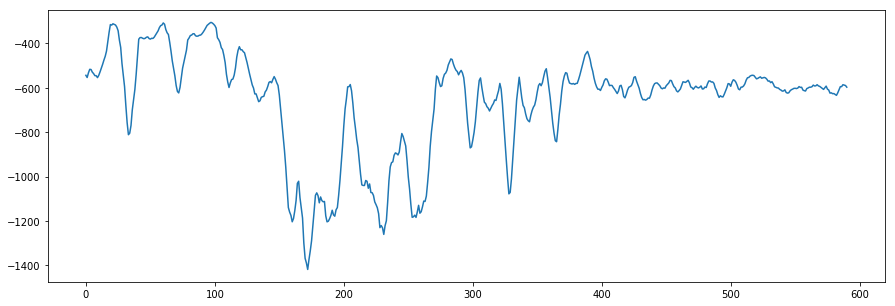

In [45]:
log = []
# f_i = 0
# score = model_vowel.score_samples(feature_syl_te[range(f_i, f_i+120)])
# print(score[0])
window_size = 8

for f_i in range(0, len(feature_syl_te)-window_size):
    score = model_vowel.score_samples(feature_syl_te[range(f_i, f_i+window_size)])
    log.append(score[0])

plt.figure(figsize=(15,5))
plt.plot(log)

### 5.3 Using sentence as tesing voice signal
<img src="Figure/sentence_ref.png" width="500"/>

### Reference
Y.-A. Lien, C. Gattuccio, and C. Stepp, “Effects of phonetic context on relative fundamental frequency,” Journal of Speech, Language, and Hearing Research, vol. 57, pp. 1259–1267, 2014.

Elizabeth S.Heller Murray, Gabrielle L. Hands, Carolyn R. Calabrese, Cara E. Stepp, Effects of Adventitious Acute Vocal Trauma: Relative Fundamental Frequency and Listener Perception, Journal of Voice, Volume 30, Issue 2, 2016, Pages 177-185.

##### Sentence 1 
“The d**ew shi**mmered over m**y shi**ny blue shell again”

In [ ]:
sentence1 = sio.loadmat('Data/%s/sentence1.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence1, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])

##### Sentence 2
“Only w**e fee**l you d**o fai**l in n**ew fa**llen dew”

In [ ]:
sentence2 = sio.loadmat('Data/%s/sentence2.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence2, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])